In [5]:
import glob
# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 
import os
genSavePath = f"{os.getcwd()}/SavedResults/"
day = "17" # Which month and days result you want to visualize in table
month = 11

repetitionValue = 27
repetitionName =  "torchTest"#  "udrli1feattestanglnoBC"  # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBest*")

saveTop = False
if saveTop:
    saveTopName = "top3udrli.npy"
else:
    saveTopName = None
topAmount = 20
skipSubjects = []
onlySignificant = True
minAcc = 0.1
print(len(savedResults))
print(len(savedResults)/9)

43
4.777777777777778


In [6]:
import pandas as pd
from array import ArrayType
from requests import delete
import numpy as np


nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0

currSeed = 0
currSubj = 0
combinationList = []

testInfoPerSubject = [None] * 10

results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
    
for subject in results:
    currSubj = subject[1]
    testInfoPerSubject[currSubj] = subject[0]
soloFeatures = []
featCombos = []
kernels = testInfoPerSubject[1][2][0]
regValues = testInfoPerSubject[1][2][1]
paradigmName = testInfoPerSubject[1][3]
for subinfo in testInfoPerSubject[1:]:
    if subinfo is None:
        continue
    subSoloFeatures = subinfo[0]
    subfeatCombos = subinfo[1]
    if len(soloFeatures) < len(subSoloFeatures):
        soloFeatures = subSoloFeatures
    if len(featCombos) < len(subfeatCombos):
        featCombos = subfeatCombos
    #print(subinfo)
allCombinations = []
comboNumber = 0
combinationDict = dict()
for featCombo in featCombos:
    for kernel in kernels:
        for regValue in regValues:
            allCombinations.append([featCombo, kernel, regValue, comboNumber])
            combinationDict[f"{featCombo},{kernel},{regValue}"] = comboNumber
            comboNumber = comboNumber + 1
#print(combinationDict)
nrOfCombination = len(allCombinations)
combinationResult = np.zeros([subjectAmount, len(allCombinations), 2])
nrOfSeedsPerSubject = np.zeros(subjectAmount)
seedCounted = np.zeros([subjectAmount, len(allCombinations), (len(savedResults)//9)+1])
currSeed = -1
for s, subject in enumerate(results):
    currSubj = 0
    
    subjectBestArray = np.empty([len(subject)], dtype=object)

    
    currSubj = subject[1]
    if currSubj == 1:
        currSeed = currSeed + 1 
    testInfoPerSubject[currSubj] = subject[0]
    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            if len(aResults2) < 6:

                aName = aResults2[0]
                ares = aResults2[1]

                # if type(ares) is tuple:
                #     ares = ares[0]
                # if ares > 0.98:
                #     ares = 0.99
                akernel = aResults2[2]
            
                aC = aResults2[3]
                if seedCounted[currSubj, combinationDict[f"{aName},{akernel},{aC}"], currSeed] == 1:
                    continue
                seedCounted[currSubj, combinationDict[f"{aName},{akernel},{aC}"], currSeed] = 1
                combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]] = [int(combinationDict[f"{aName},{akernel},{aC}"]), 
                                                                                           combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][1] + ares]
               

for subNr, subj in enumerate(combinationResult[1:], 1):
    combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / nrOfSeedsPerSubject[subNr]
    if "adaBoost" in kernels:
        combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / 2

headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
topPerFeature = np.zeros([10, len(featCombos)])

lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        for res in cResult:
    
            cmbNr = int(res[0])

            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
            comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
            nrOfSubjects[cmbNr] += 1
            subjectResultArray[subNr, cmbNr] = res[1]
            comboName = allCombinations[cmbNr][0]

            nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
            
   
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort()
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()
                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort()
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
        
        
        
# Print the table!
comboAverage = comboAverage / nrOfSubjects
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
for hcol, in zip(headers):
    if all(subjectResultArray[:,hcol] == None):
        atleastOneEmpty = True
        emptyCols.append(hcol)
if atleastOneEmpty: 
    subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    headers = np.delete(headers, np.array(emptyCols),0)
    comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)




/tmp/ipykernel_48629/1082744460.py:162: RuntimeWarning: invalid value encountered in true_divide
  comboAverage = comboAverage / nrOfSubjects


,144,150,151,152,153,154,155,156,157,158,159,160,161
0,None,None,None,None,None,None,None,None,None,None,None,None,None
1,0.67,0.67,0.68,0.69,0.69,0.69,0.69,0.675,0.7,0.695,0.68,0.68,0.675
2,0.566667,0.529167,0.566667,0.6375,0.625,0.633333,0.633333,0.520833,0.5625,0.583333,0.595833,0.55,0.508333
3,0.427778,0.416667,0.422222,0.422222,0.427778,0.427778,0.427778,0.416667,0.422222,0.422222,0.427778,0.416667,0.4
4,0.404167,0.429167,0.429167,0.4625,0.429167,0.429167,0.429167,0.404167,0.445833,0.45,0.4,0.4,0.3875
5,0.395833,0.3875,0.391667,0.425,0.416667,0.4,0.4,0.366667,0.420833,0.4,0.408333,0.3875,0.383333
6,0.568182,0.559091,0.568182,0.568182,0.568182,0.568182,0.568182,0.577273,0.590909,0.586364,0.568182,0.554545,0.577273
7,0.55,0.55,0.554167,0.570833,0.566667,0.566667,0.566667,0.570833,0.55,0.570833,0.558333,0.529167,0.529167
8,0.34375,0.35625,0.35625,0.35625,0.3625,0.35625,0.35,0.35625,0.35625,0.35625,0.35625,0.3625,0.36875
9,0.6875,0.734375,0.734375,0.75,0.744792,0.744792,0.744792,0.703125,0.713542,0.708333,0.703125,0.697917,0.713542


In [7]:
pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
table = pd.DataFrame(topPerFeature, columns=featCombos)
display(table)


,fftData_BC_&_fftData_BC_&_fftData_BC,fftData_BC_&_fftData_BC_&_fftData_BC,fftData_BC_&_fftData_BC_&_fftData_BC,fftData_BC_&_fftData_BC_&_fftData_BC,fftData_BC_&_fftData_BC_&_fftData_BC,fftData_BC_&_fftData_BC_&_fftData_BC,fftData_BC_&_fftData_BC_&_fftData_BC,fftData_BC_&_fftData_BC_&_fftData_BC,fftData_BC_&_fftData_BC_&_fftData_BC
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.700000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.637500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.427778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.462500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.425000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.590909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.570833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.368750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(9,)



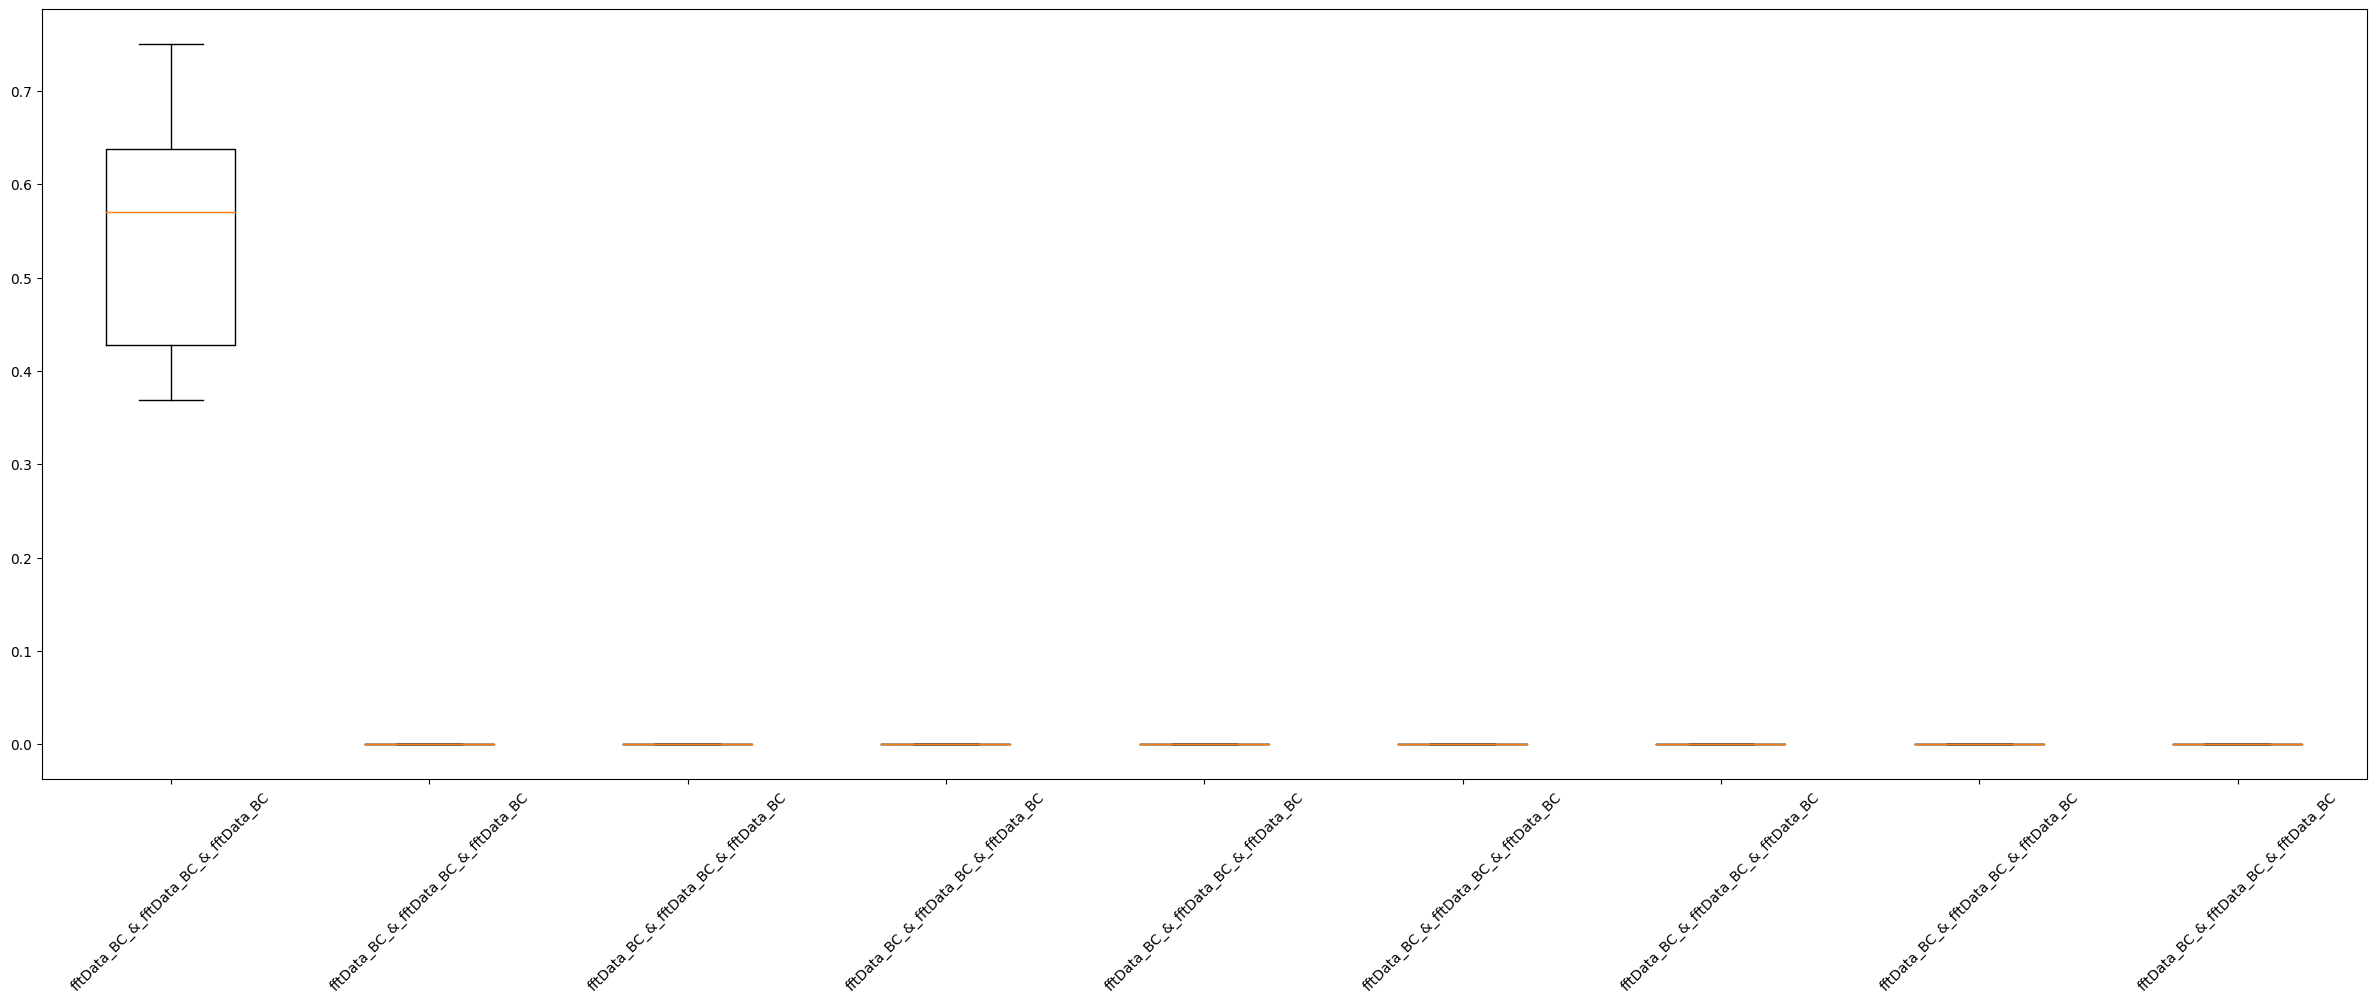

In [8]:
import matplotlib.pyplot as plt
meanTop = np.mean(topPerFeature[1:], axis=0)
indices = np.argsort(meanTop, axis=0)[::-1]

print(indices.shape)
featCombos = np.array(featCombos)

if len(featCombos) < 30:
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(len(featCombos[indices][:30]))+1,featCombos[indices][:30],rotation=45)
    print("")
else: 
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(30)+1,featCombos[indices][:30],rotation=90)
    print("")
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:10])
    plt.xticks(np.arange(10)+1,featCombos[indices][:10],rotation=20)
    print("")
    


In [9]:
print("Top ten highest accuracies")

topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.75 : subject 9, feature:fftData_BC_&_fftData_BC_&_fftData_BC, kernelrbf, C:1.2
Accuracy 0.74 : subject 9, feature:fftData_BC_&_fftData_BC_&_fftData_BC, kernelrbf, C:10
Accuracy 0.74 : subject 9, feature:fftData_BC_&_fftData_BC_&_fftData_BC, kernelrbf, C:5
Accuracy 0.74 : subject 9, feature:fftData_BC_&_fftData_BC_&_fftData_BC, kernelrbf, C:2.5
Accuracy 0.73 : subject 9, feature:fftData_BC_&_fftData_BC_&_fftData_BC, kernelrbf, C:0.5
Accuracy 0.73 : subject 9, feature:fftData_BC_&_fftData_BC_&_fftData_BC, kernelrbf, C:0.1
Accuracy 0.71 : subject 9, feature:fftData_BC_&_fftData_BC_&_fftData_BC, kernelsigmoid, C:10
Accuracy 0.71 : subject 9, feature:fftData_BC_&_fftData_BC_&_fftData_BC, kernelsigmoid, C:0.5
Accuracy 0.71 : subject 9, feature:fftData_BC_&_fftData_BC_&_fftData_BC, kernelsigmoid, C:1.2
Accuracy 0.7 : subject 9, feature:fftData_BC_&_fftData_BC_&_fftData_BC, kernelsigmoid, C:2.5


In [10]:
print("Top ten highest accuracies")
for subTop in topThreeAllSubjects:
    subTop.reverse()

Top ten highest accuracies


In [11]:
topThreeAllSubjects.sort(reverse=True)
arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects:
    print("")
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )

arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    skip = False  
    
    newArrayOfTopFeatureNames.append(splitArray)
    
print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)



Accuracy 0.75 : subject 9, feature:fftData_BC_&_fftData_BC_&_fftData_BC, kernelrbf, C:1.2

Accuracy 0.7 : subject 1, feature:fftData_BC_&_fftData_BC_&_fftData_BC, kernelsigmoid, C:0.5

Accuracy 0.64 : subject 2, feature:fftData_BC_&_fftData_BC_&_fftData_BC, kernelrbf, C:1.2

Accuracy 0.59 : subject 6, feature:fftData_BC_&_fftData_BC_&_fftData_BC, kernelsigmoid, C:0.5

Accuracy 0.57 : subject 7, feature:fftData_BC_&_fftData_BC_&_fftData_BC, kernelsigmoid, C:1.2

Accuracy 0.46 : subject 4, feature:fftData_BC_&_fftData_BC_&_fftData_BC, kernelrbf, C:1.2

Accuracy 0.43 : subject 3, feature:fftData_BC_&_fftData_BC_&_fftData_BC, kernelrbf, C:2.5

Accuracy 0.42 : subject 5, feature:fftData_BC_&_fftData_BC_&_fftData_BC, kernelrbf, C:1.2

Accuracy 0.37 : subject 8, feature:fftData_BC_&_fftData_BC_&_fftData_BC, kernelsigmoid, C:10
[array(['fftData_BC', 'fftData_BC', 'fftData_BC'], dtype=object), array(['fftData_BC', 'fftData_BC', 'fftData_BC'], dtype=object), array(['fftData_BC', 'fftData_BC', '

In [12]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])



[0.         0.68346154 0.57788462 0.42136752 0.42307692 0.39871795
 0.57097902 0.55641026 0.35673077 0.72155449]


,144,150,151,152,153,154,155,156,157,158,159,160,161
0,0.512653,0.514691,0.522522,0.542499,0.53675,0.53513,0.534435,0.51009,0.529121,0.53026,0.521982,0.508699,0.504766


Max average accuracy 0.5424985970819304


In [13]:
print("Based on combAverage")
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
for maxInd,res in zip(top5, top5Vals):
    #print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combAverage
fftData_BC_&_fftData_BC_&_fftData_BC
rbf
0.5424985970819304

fftData_BC_&_fftData_BC_&_fftData_BC
rbf
0.5367501402918069

fftData_BC_&_fftData_BC_&_fftData_BC
rbf
0.5351297699214366

fftData_BC_&_fftData_BC_&_fftData_BC
rbf
0.534435325476992

fftData_BC_&_fftData_BC_&_fftData_BC
sigmoid
0.5302595398428731



In [14]:
print("Based on combTotal")
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combTotal
fftData_BC_&_fftData_BC_&_fftData_BC
rbf
0.5424985970819304

fftData_BC_&_fftData_BC_&_fftData_BC
rbf
0.5367501402918069

fftData_BC_&_fftData_BC_&_fftData_BC
rbf
0.5351297699214366

fftData_BC_&_fftData_BC_&_fftData_BC
rbf
0.534435325476992

fftData_BC_&_fftData_BC_&_fftData_BC
sigmoid
0.5302595398428731



In [15]:
table = pd.DataFrame(np.array(comboTotal), columns=headers)
display(table)

maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

for maxInd2 in np.where(comboTotal == maxVal2)[1]:
    print(headers[maxInd2])
    print(nrOfSubjects[maxInd2])
    print(
        f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
    )
    print(allCombinations[maxInd2][0])
    print(allCombinations[maxInd2][1])
    print(f"C: {allCombinations[maxInd2][2]} ")


,144,150,151,152,153,154,155,156,157,158,159,160,161
0,4.613876,4.632216,4.702696,4.882487,4.830751,4.816168,4.809918,4.590814,4.76209,4.772336,4.697835,4.578295,4.542898


152
9.0
Max total significant accuracy then averaged 0.5424985970819304 
fftData_BC_&_fftData_BC_&_fftData_BC
linear
C: 2.5 


In [16]:
for names in featCombos:
    print(names)



fftData_BC_&_fftData_BC_&_fftData_BC
fftData_BC_&_fftData_BC_&_fftData_BC
fftData_BC_&_fftData_BC_&_fftData_BC
fftData_BC_&_fftData_BC_&_fftData_BC
fftData_BC_&_fftData_BC_&_fftData_BC
fftData_BC_&_fftData_BC_&_fftData_BC
fftData_BC_&_fftData_BC_&_fftData_BC
fftData_BC_&_fftData_BC_&_fftData_BC
fftData_BC_&_fftData_BC_&_fftData_BC
